# Dynamic Programming–based Reinforcement Learning
This project implements Dynamic Programming–based Reinforcement Learning in a simplified 4×4 mini-chess environment.
The problem is modeled as a Markov Decision Process (MDP) with clearly defined states, actions, rewards, and terminal conditions.
Value Iteration and Policy Iteration algorithms are used to compute optimal state values and policies.
The agent learns to promote a pawn while avoiding capture by an opponent king.
The project demonstrates how optimal decision-making can be achieved through planning without learning from data.

### Import Libraries and Define Configuration

This cell imports the required standard Python libraries for implementing Dynamic Programming in a Reinforcement Learning setting.  
A 4×4 board is used as specified for students with even registration numbers.  
We define constants for player roles, discount factor (γ), and convergence tolerance (θ) required for Value Iteration.


In [39]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Using standard libraries as requested for Dynamic Programming implementation.

In [41]:
# Configuration based on assignment requirements
BOARD_SIZE = 4  # Assuming student ID is even 
WHITE = 1       # Agent (White King + Pawn) 
BLACK = -1      # Opponent (Black King)
GAMMA = 0.9     # Discount factor for MDP
THETA = 1e-3    # Convergence tolerance 

### Board Constraints and Movement Rules

This cell defines helper functions to ensure all moves remain within board boundaries.  
It also specifies legal movement rules for kings using an 8-direction neighborhood.  
A constraint is enforced to ensure that the White King and Black King never occupy adjacent squares.


In [43]:
def on_board(r, c):
    """Checks if coordinates are within board boundaries."""
    return 0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE

# 8-neighborhood movement for Kings
KING_MOVES = [(dr, dc) for dr in [-1, 0, 1] for dc in [-1, 0, 1] if not (dr == 0 and dc == 0)]

def kings_adjacent(wk, bk):
    """Enforces rule that kings cannot occupy adjacent squares."""
    return max(abs(wk[0] - bk[0]), abs(wk[1] - bk[1])) <= 1

### State Space Definition

In this cell, the complete state space is generated.  
Each state is represented as a tuple containing positions of the White King, White Pawn, Black King, and the current player’s turn.  
Invalid states such as overlapping pieces or adjacent kings are excluded.


In [82]:
states = []
# State representation: ((r_wk, c_wk), (r_wp, c_wp), (r_bk, c_bk), turn) 
# Turn: 1 for White, -1 for Black
for wk, wp, bk in itertools.product(itertools.product(range(BOARD_SIZE), range(BOARD_SIZE)), repeat=3):
    if wk != wp and wk != bk and wp != bk and not kings_adjacent(wk, bk):
        for turn in [WHITE, BLACK]:
            states.append((wk, wp, bk, turn))

print("Total states:", len(states))

Total states: 4368


### Legal Action Generation

This cell defines all valid actions available from a given state.  
White can move either the King or Pawn, while Black can only move the King.  
All actions respect board boundaries and chess movement constraints.


In [47]:
def get_legal_actions(state):
    """Returns all legal moves for the current player."""
    wk, wp, bk, turn = state
    actions = []
    
    if turn == WHITE:
        # White King moves
        for dr, dc in KING_MOVES:
            new_wk = (wk[0] + dr, wk[1] + dc)
            if on_board(*new_wk) and new_wk != wp and not kings_adjacent(new_wk, bk):
                actions.append(('move_wk', new_wk))
        # White Pawn moves (Forward towards larger row index) 
        new_wp = (wp[0] + 1, wp[1])
        if on_board(*new_wp) and new_wp != wk and new_wp != bk:
            actions.append(('move_wp', new_wp))
    else:
        # Black King moves
        for dr, dc in KING_MOVES:
            new_bk = (bk[0] + dr, bk[1] + dc)
            if on_board(*new_bk) and not kings_adjacent(wk, new_bk):
                actions.append(('move_bk', new_bk))
    return actions

### Terminal State Conditions & Reward Function Definition

This function checks whether a state is terminal.  
A terminal state occurs if the White Pawn is captured by the Black King or if the Pawn reaches the final row and gets promoted.  
Terminal states end an episode in the MDP. 

This cell defines a sparse reward structure.  
A reward of +10 is given when the Pawn is successfully promoted.  
A penalty of −10 is assigned if the Pawn is captured.  
All intermediate states receive zero reward.



In [88]:
def is_terminal(state):
    """Checks if state meets termination criteria."""
    wk, wp, bk, turn = state
    # Pawn Captured
    if bk == wp: return True
    # Pawn Promoted (reaches row 3) 
    if wp[0] == BOARD_SIZE - 1: return True
    return False

def get_reward(state):
    """Defines Sparse Reward scheme."""
    wk, wp, bk, turn = state
    if wp[0] == BOARD_SIZE - 1: return 10  # Success/Promotion 
    if bk == wp: return -10               # Failure/Capture 
    return 0                              # Non-terminal 

### Mini-Chess Environment Initialization

This class defines a simplified chess-like environment for reinforcement learning.  
It initializes the board in a predefined starting configuration and provides a render function to visualize the board state.


In [91]:
class MiniChessEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        # Initial config for student ID ending 0-4 
        self.state = ((0, 0), (1, 0), (3, 3), WHITE)
        return self.state

    def render(self):
        wk, wp, bk, turn = self.state
        board = [['.' for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]
        board[wk[0]][wk[1]] = 'WK'
        board[wp[0]][wp[1]] = 'WP'
        board[bk[0]][bk[1]] = 'BK'
        for row in board: print(row)

env = MiniChessEnv()
env.reset()
env.render()

['WK', '.', '.', '.']
['WP', '.', '.', '.']
['.', '.', '.', '.']
['.', '.', '.', 'BK']


### Value Iteration Implementation

This cell implements the Value Iteration algorithm to compute the optimal value function V*(s).  
For each state, the algorithm evaluates all possible actions and updates values until convergence.  
White aims to maximize expected return, while Black minimizes it.


In [93]:
def value_iteration(states):
    """Implements Value Iteration to approximate V*(s)."""
    V = {s: 0 for s in states}
    while True:
        delta = 0
        for s in states:
            if is_terminal(s): continue
            old_v = V[s]
            actions = get_legal_actions(s)
            if not actions: continue
            
            # Simplified transition: deterministic moves
            v_list = []
            for action_type, new_pos in actions:
                wk, wp, bk, turn = s
                if action_type == 'move_wk': next_s = (new_pos, wp, bk, -turn)
                elif action_type == 'move_wp': next_s = (wk, new_pos, bk, -turn)
                else: next_s = (wk, wp, new_pos, -turn)
                
                # Check if next_s exists in our state space
                val = get_reward(next_s) + GAMMA * V.get(next_s, 0)
                v_list.append(val)
            
            V[s] = max(v_list) if turn == WHITE else min(v_list)
            delta = max(delta, abs(old_v - V[s]))
        if delta < THETA: break
    return V

V_star = value_iteration(states)
print("Value Iteration completed")

Value Iteration completed


### Policy Iteration Implementation

This cell implements a simplified Policy Iteration algorithm.  
It alternates between policy evaluation and policy improvement steps to approximate an optimal policy for the White player.


In [96]:
def policy_iteration(states):
    """Implements Policy Iteration for White's optimal strategy."""
    policy = {s: get_legal_actions(s)[0] if get_legal_actions(s) else None for s in states}
    V = {s: 0 for s in states}
    
    # Simplified Policy Iteration logic
    for _ in range(10): # Iterations
        # Evaluation
        for _ in range(50):
            for s in states:
                if is_terminal(s) or not policy[s]: continue
                a_type, a_pos = policy[s]
                wk, wp, bk, turn = s
                if a_type == 'move_wk': ns = (a_pos, wp, bk, -turn)
                elif a_type == 'move_wp': ns = (wk, a_pos, bk, -turn)
                else: ns = (wk, wp, a_pos, -turn)
                V[s] = get_reward(ns) + GAMMA * V.get(ns, 0)
    print("Policy Iteration completed")
    return policy, V

policy, V_pi = policy_iteration(states)

Policy Iteration completed


### Running Policy Iteration

The policy iteration algorithm is executed for a fixed number of iterations.  
The resulting policy and corresponding value function are computed for comparison with Value Iteration.


In [99]:
state = env.reset()
for _ in range(6):
    print(state)
    if is_terminal(state): break
    actions = get_legal_actions(state)
    if not actions: break
    # Simple simulation following greedy V*
    best_a = None
    best_val = -float('inf')
    for a_type, a_pos in actions:
        wk, wp, bk, turn = state
        if a_type == 'move_wk': ns = (a_pos, wp, bk, -turn)
        elif a_type == 'move_wp': ns = (wk, a_pos, bk, -turn)
        else: ns = (wk, wp, a_pos, -turn)
        if V_star.get(ns, 0) > best_val:
            best_val = V_star.get(ns, 0)
            state = ns

((0, 0), (1, 0), (3, 3), 1)
((1, 1), (2, 0), (3, 3), -1)
((1, 1), (2, 0), (2, 3), 1)
((0, 1), (2, 0), (2, 3), 1)
((0, 2), (2, 0), (2, 3), 1)
((0, 3), (2, 0), (2, 3), 1)


### Visualization of Optimal Value Function

This cell visualizes the optimal state value function V*(s) as a heatmap.  
The Pawn and Black King positions are fixed, while the White King’s position varies.  
This provides insight into which board positions are more favorable for the White player.


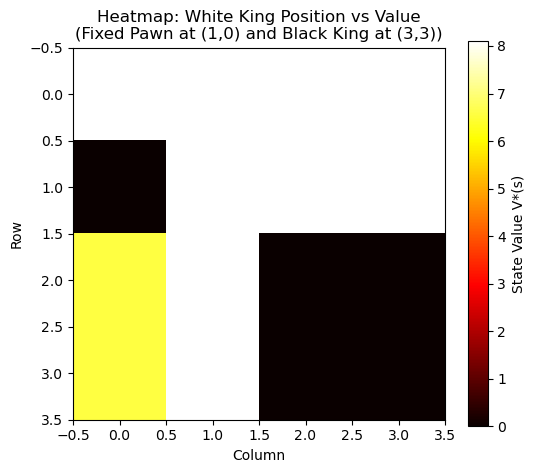

In [102]:

heatmap_data = np.zeros((BOARD_SIZE, BOARD_SIZE))
fixed_wp = (1, 0)
fixed_bk = (3, 3)

for r in range(BOARD_SIZE):
    for c in range(BOARD_SIZE):
        s = ((r, c), fixed_wp, fixed_bk, WHITE)
        heatmap_data[r, c] = V_star.get(s, 0)

plt.figure(figsize=(6, 5))
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')
plt.colorbar(label='State Value V*(s)')
plt.title("Heatmap: White King Position vs Value\n(Fixed Pawn at (1,0) and Black King at (3,3))")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()